In [2]:
import csv

filename = "dataset/nl_fol_3d_modelling_dataset.csv"

In [3]:
f = open(filename, "r")

reader = csv.DictReader(f)

ds = []
for row in reader:
    ds.append(row)
    
print(ds)

[{'NL Sentence': 'There exists a box with length and height and width.', 'FOL Formula': 'exists x (is_box(x) & with_length(x) & with_height(x) & with_width(x))'}, {'NL Sentence': 'The pipe has a simple hole with diameter.', 'FOL Formula': 'exists x exists y (is_pipe(x) & has_hole(x, y) & is_simple(y) & with_diameter(y))'}, {'NL Sentence': 'There exists a pipe with diameter.', 'FOL Formula': 'exists x (is_pipe(x) & with_diameter(x))'}, {'NL Sentence': 'There exists a coil with diameter and revol and height and angle and section size.', 'FOL Formula': 'exists x (is_coil(x) & with_diameter(x) & with_revol(x) & with_height(x) & with_angle(x) & with_section size(x))'}, {'NL Sentence': 'There is a arc on the YZ plane with center and start and end.', 'FOL Formula': 'exists x (is_arc(x) & on_yz(x) & with_center(x) & with_start(x) & with_end(x))'}, {'NL Sentence': 'There exists a pipe with diameter.', 'FOL Formula': 'exists x (is_pipe(x) & with_diameter(x))'}, {'NL Sentence': 'There is a arc on

In [25]:
ds_size = len(ds)
train_size = int(ds_size * 0.3)
test_size = int(ds_size * 0.03)
val_size = int(ds_size * 0.008)

train = ds[:train_size]
test = ds[train_size:train_size + test_size]
valid = ds[train_size + test_size: train_size + test_size + val_size]

In [26]:
print("Training set length:", len(train))
print("Validation set length:", len(valid))
print("Test set length:", len(test))

Training set length: 1500
Validation set length: 40
Test set length: 150


In [27]:
INSTRUCTION = "Translate the following input into the first-order logic statement."

In [28]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{INSTRUCTION}"
    )

    input_text = f"\n\n### Input:\n{entry['NL Sentence']}" if entry["NL Sentence"] else ""

    return instruction_text + input_text

In [29]:
model_input = format_input(train[50])
desired_response = f"\n\n### Response:\n{train[50]['FOL Formula']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Translate the following input into the first-order logic statement.

### Input:
There exists a box with length and height and width.

### Response:
exists x (is_box(x) & with_length(x) & with_height(x) & with_width(x))


In [30]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['FOL Formula']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [31]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [32]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cpu


In [34]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [35]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 15

torch.manual_seed(123)

train_dataset = InstructionDataset(train, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(valid, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [36]:

from gpt.util.gpt_generate import init_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
model = init_gpt(BASE_CONFIG, model_size)

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


In [37]:
from gpt.training import (
    calc_loss_loader,
    train_model_simple
)

In [38]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.56542911529541
Validation loss: 3.6082791487375894


In [39]:
import time

start_time = time.time()

torch.manual_seed(100)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(valid[0])
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.703, Val loss 2.701
Ep 1 (Step 000005): Train loss 0.681, Val loss 0.711
Ep 1 (Step 000010): Train loss 0.295, Val loss 0.263
Ep 1 (Step 000015): Train loss 0.166, Val loss 0.160
Ep 1 (Step 000020): Train loss 0.100, Val loss 0.100
Ep 1 (Step 000025): Train loss 0.082, Val loss 0.092
Ep 1 (Step 000030): Train loss 0.081, Val loss 0.072
Ep 1 (Step 000035): Train loss 0.063, Val loss 0.069
Ep 1 (Step 000040): Train loss 0.060, Val loss 0.065
Ep 1 (Step 000045): Train loss 0.065, Val loss 0.069
Ep 1 (Step 000050): Train loss 0.057, Val loss 0.062
Ep 1 (Step 000055): Train loss 0.056, Val loss 0.060
Ep 1 (Step 000060): Train loss 0.063, Val loss 0.063
Ep 1 (Step 000065): Train loss 0.061, Val loss 0.061
Ep 1 (Step 000070): Train loss 0.055, Val loss 0.060
Ep 1 (Step 000075): Train loss 0.055, Val loss 0.059
Ep 1 (Step 000080): Train loss 0.055, Val loss 0.058
Ep 1 (Step 000085): Train loss 0.053, Val loss 0.053
Ep 1 (Step 000090): Train loss 0.056, Val loss

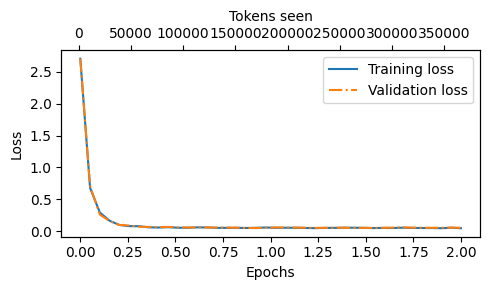

In [40]:
from gpt.training import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [42]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-shp.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")


Model saved as gpt2-medium355M-shp.pth
